## TL;DR
In cross validation we choose some number of folds. That number can range from 2 (train on 50%, test on 50%) to N (Leave-One-Out cross validation). We could also just have a held-out validation set. 

More folds mean:

1) We have more estimates of out-of-sample error [good]  
2) Our model gets to train on a larger number of points [good]  
3) Each estimate is based on fewer test/validation points [bad]  
4) Each estimate is more correlated [bad]  
5) We spend more time repeatedly fitting our model [bad]

Net: cross validation is much lower-variance than estimating via a pure validation set. 4 or 5 folds gets great varaince reduction with relatively low computational cost.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.special
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

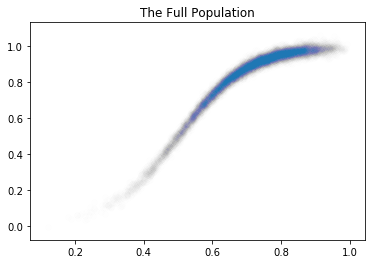

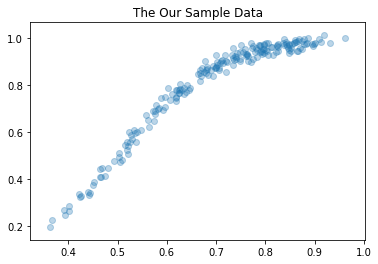

In [2]:
pop_size=1000000
graph_size=10000
sample_size=200
n_folds = 5
degree = 2
reps = 500

def get_data(sample_size):
    x_data = np.random.beta(7,3, size=sample_size)
    y_data = scipy.special.expit(x_data*10 -5) + np.random.normal(0,.02,size=sample_size)
    return x_data, y_data

# get a big sample
x_population, y_population = get_data(graph_size)

plt.scatter(x_population, y_population, alpha=.003)
plt.title("The Full Population")
plt.show()


# get a dataset-size sample
x_sample, y_sample = get_data(sample_size)

plt.scatter(x_sample, y_sample, alpha=.3)
plt.title("The Our Sample Data")
plt.show()

As is usual, we have a population, and a sample from the population. Here we have a dataset with 200 observations.

In [3]:
# given sample data, figure out how well a model based on that sample
# does against the whole population
# (Not exact, but stable to 2-3 decimal places)
def get_true_score(x_data,y_data):
    
    #fit a model on the sample data
    x_data_poly = PolynomialFeatures(degree).fit_transform(x_data.reshape(-1,1))
    lr_model = LinearRegression(fit_intercept=False)
    fitted_model = lr_model.fit(x_data_poly,y_data)

    #approximate true out-of-sample performance by scoring on a large sample
    x_full_data, y_full_data = get_data(pop_size)
    x_full_data_poly = PolynomialFeatures(degree).fit_transform(x_full_data.reshape(-1,1))

    true_score = fitted_model.score(x_full_data_poly,y_full_data)
    return true_score

true_score = get_true_score(x_sample,y_sample)
print("Model's true out-of-sample performance is:",true_score)

Model's true out-of-sample performance is: 0.969562276509


With this sample, we get and R^2 value of about .969, based on a very large test set. This figure is approximate, but stable to 2-3 decimal places.

So, now that we know the answer, let's compare cross validation and regular validation

Starting 2-fold calculations
Starting 3-fold calculations
Starting 4-fold calculations
Starting 5-fold calculations
Starting 6-fold calculations
Starting 7-fold calculations
Starting 8-fold calculations
Starting 9-fold calculations
Starting 10-fold calculations
Starting 15-fold calculations
Starting 20-fold calculations
Starting 2-fold calculations
Starting 3-fold calculations
Starting 4-fold calculations
Starting 5-fold calculations
Starting 6-fold calculations
Starting 7-fold calculations
Starting 8-fold calculations
Starting 9-fold calculations
Starting 10-fold calculations
Starting 15-fold calculations
Starting 20-fold calculations


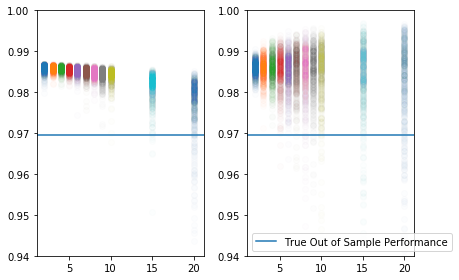

In [4]:
def get_cv_score(lr_model, n_folds, x_sample_poly, y_sample):
    splitter = KFold(n_folds, shuffle=True)
    scores = cross_val_score(lr_model, x_sample_poly, y_sample, cv=splitter)
    return np.mean(scores)

def get_validation_score(lr_model, n_folds, x_sample_poly, y_sample):
    splitter = KFold(n_folds, shuffle=True)
    train_idx, val_idx = next(splitter.split(x_sample_poly))

    train_x, train_y = x_sample_poly[train_idx], y_sample[train_idx]
    val_x, val_y = x_sample_poly[val_idx], y_sample[val_idx]

    fitted_model = lr_model.fit(train_x,train_y)
    return fitted_model.score(val_x,val_y)

def plot_oos_estimates(ax, score_function, x_sample_poly, y_sample, reps):
    for n_folds in [2,3,4,5,6,7,8,9,10,15,20]:
        if reps>100:
            print("Starting {}-fold calculations".format(n_folds))
        cv_scores=np.empty(reps)
        for rep in range(reps):
            cv_scores[rep] = score_function(lr_model, n_folds, x_sample_poly, y_sample)
        ax.scatter(np.full(reps, n_folds, dtype='int32') , cv_scores, alpha=.01)
    ax.axhline(true_score)
    ax.set_ylim(.94,1);

x_sample_poly = PolynomialFeatures(degree).fit_transform(x_sample.reshape(-1,1))
lr_model = LinearRegression(fit_intercept=False)

fig, ax = plt.subplots(1,2)
plot_oos_estimates(ax[0], get_cv_score, x_sample_poly, y_sample, reps)
plot_oos_estimates(ax[1], get_validation_score, x_sample_poly, y_sample, reps)
plt.legend(["True Out of Sample Performance"]);
plt.tight_layout()

#### Reading the graph
The left graph shows the estimates from 500 different cross validations at each number of folds (each using the 200 point dataset but splitting it differently), the right graph shows the estimates from 500 different train/validation splits of size matching the validation sets in the left graph. 

Overall, when we do an n-fold cross validation, the estimated out-of-sample estimate we happen to see is a draw from the left graph. If we used a totaly separate validation set, the estimated out-of-sample estimate we happen to see is a draw from the right graph.

The true out of sample performance (estiamted from a very large test set) is shown as a horizontal line.

**Caveat** the horizontal line is the performance of a model trained on the whole 200 point dataset. This line will typically be higher than the CV and regular validation estimates, since the line is drawn for a model that got to train on (slightly) more points.

#### Intepretation
1) cross-validation has MUCH less variability than a validation set of the same size, and for small numbers of folds they more or less agree on average. Thus cross-validation is a far better way of estimating out-of-sample error.  
2) Cross validation's spread increases as the number of folds increases. Not only does increasing the number of folds have diminishing returns, it can be actively harmful to accuracy.  
3) The estimate that either method gives back can be badly biased, especially for small datasets. This should be immediately shocking for a pure validation set. The horizontal line is found via a a model on 200 points and a held-out set of size 1,000,000 and the leftmost points on the right graph are training on a dataset of size 100 and validating on a dataset of size 100. The validation set may just be too small for the LLN to kick in 

### With a Larger Sample

Starting 2-fold calculations
Starting 3-fold calculations
Starting 4-fold calculations
Starting 5-fold calculations
Starting 6-fold calculations
Starting 7-fold calculations
Starting 8-fold calculations
Starting 9-fold calculations
Starting 10-fold calculations
Starting 15-fold calculations
Starting 20-fold calculations
Starting 2-fold calculations
Starting 3-fold calculations
Starting 4-fold calculations
Starting 5-fold calculations
Starting 6-fold calculations
Starting 7-fold calculations
Starting 8-fold calculations
Starting 9-fold calculations
Starting 10-fold calculations
Starting 15-fold calculations
Starting 20-fold calculations


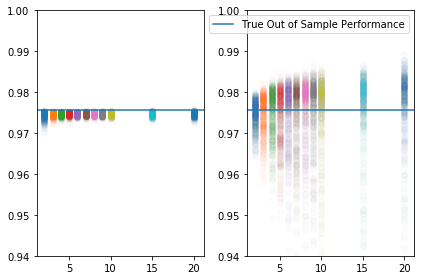

In [5]:
sample_size=2000

# get a dataset
x_sample, y_sample = get_data(sample_size)

true_score = get_true_score(x_sample,y_sample)

x_sample_poly = PolynomialFeatures(degree).fit_transform(x_sample.reshape(-1,1))

#Plot
fig, ax = plt.subplots(1,2)
plot_oos_estimates(ax[0], get_cv_score, x_sample_poly, y_sample, reps)
plot_oos_estimates(ax[1], get_validation_score, x_sample_poly, y_sample, reps)
plt.legend(["True Out of Sample Performance"]);
plt.tight_layout()

The above graphs duplicate the previous ones, but for a dataset of size 2000. Now the rightmost points come from a validation set size of 100 points, instead of just 10.

### Interpretation
1) We still see that cross-validation has MUCH lower variance
2) We see that both methods slightly underestimate the performance of a model trained on the full training data
3) The variance in the cross-validation estimates stays relatively flat, but is still minimized somewhere around k=5. (And the computational costs of larger k are still severe)

## Summary
When estimating out-of-sample performance 5-fold cross validation is a very good choice. It has substantially lower variance than a validation set of the same size, albeit at 5x the cost of fitting the model. If you have the computational resources, though, cross validation will give a substantially more accurate estimate of how well a given model performs.

## Averaging Across Datasets
The above analysis mirrored real life in that we got som particular dataset- maybe lucky, maybe unlucky. However, we could mirror real life in another way: when designing an experiment we don't know if our dataset will be lucky or unlucky. How do the above results change if we average across lots of possible datasets instead of just running with a particular one?

0
50
100
150
200
250
300
350
400
450
0
50
100
150
200
250
300
350
400
450


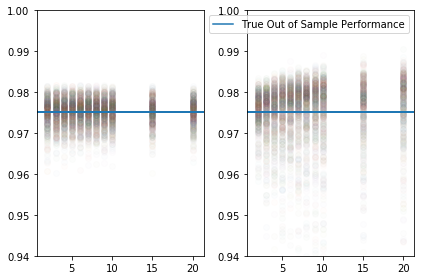

In [7]:
sample_size=2000
reps=500

#find true score, averaged across datasets
scores=np.empty(reps)
for rep in range(reps):
    if (rep % 50)==0:
        print(rep)
    # get a dataset
    x_sample, y_sample = get_data(sample_size)
    
    #model on full training data
    x_sample_poly = PolynomialFeatures(degree).fit_transform(x_sample.reshape(-1,1))
    lr_model = LinearRegression(fit_intercept=False)
    fitted_model = lr_model.fit(x_sample_poly,y_sample)
    
    x_population, y_population = get_data(graph_size)
    x_pop_poly = PolynomialFeatures(degree).fit_transform(x_population.reshape(-1,1))
    
    scores[rep] = fitted_model.score(x_pop_poly,y_population)

true_score=np.mean(scores)
#Plot
fig, ax = plt.subplots(1,2)

for rep in range(reps):
    if (rep % 50)==0:
        print(rep)
    # get a dataset
    x_sample = np.random.beta(7,3, size=sample_size)
    y_sample = scipy.special.expit(x_sample*10 -5) + np.random.normal(0,.02,size=sample_size)

    #model on full training data
    x_sample_poly = PolynomialFeatures(degree).fit_transform(x_sample.reshape(-1,1))
    lr_model = LinearRegression(fit_intercept=False)
    fitted_model = lr_model.fit(x_sample_poly,y_sample)
    
    #toss up a CV and validation estimate seen on this dataset
    plot_oos_estimates(ax[0], get_cv_score, x_sample_poly, y_sample, 1)
    plot_oos_estimates(ax[1], get_validation_score, x_sample_poly, y_sample, 1)

    
plt.legend(["True Out of Sample Performance"]);
plt.tight_layout()

### Interpretation
The results shouldn't be too surprising. 

With a large dataset  
1) Cross validation continues to have a lower variance
2) Both forms of validation are close to unbiased, but on average too pessimistic compared to a model trained on the full training dataset.

## Conclusion
If you have the computing power, use 4 or 5 fold cross validation. It's lower variance than a pure validation set. Going to greater numbers of folds costs computational power and doesn't give much benefit (and can even hurt in small datasets).

Leave-one-out cross validation is the same as maxing out the number of folds, and is thus extremely high variance. It's really only a thing becuase you can get it for free when fitting certain models. Only use it as an estimate of out-of-sample performance if you have a TON of data in your training set.